# CPU Cycles and Degrees of Data Selectivity

This experiment evaluates the cost of total CPU cycles during transferring different percentages of the whole **dataset (1GB)** from multiple servers to a client using a simple data filtering function. The transmission size range from 10% to 90% of the dataset, which is generated/filled with only digits under uniform distribution, to represent different degrees of data selectivity.

## Data Filtering Function

The data filtering function we evaluated in this experiment is a lambda function
```python
lambda v: v - 48 < BELOW
```
where v is the **ascii code** of the current char and `BELOW` between 0 and 10 is for controlling the degree of data selectivity.

For each byte in the dataset, we use the above function to check if the current byte should be transmitted. Specifically, a smaller `BELOW` results in high data selectivity while bigger `BELOW` permits more bytes in the dataset to be transmitted meaning low data selectivity in other words.

## Experiment Setup

### Machine Configuration

1 client node and 8 server nodes are all the same machine type from cloudlab:

**xl170**   Intel Broadwell, 10 core, 1 disk

---
```
CPU     Ten-core Intel E5-2640v4 at 2.4 GHz 
RAM     64GB ECC Memory (4x 16 GB DDR4-2400 DIMMs)
Disk    Intel DC S3520 480 GB 6G SATA SSD 
NIC     Two Dual-port Mellanox ConnectX-4 25 GB NIC (PCIe v3.0, 8 lanes
```
---

Experiment Network Speed: 25000Mb/s

### Methodology

We use both [`iostat`](http://man7.org/linux/man-pages/man1/iostat.1.html) and [`perf stat`](https://perf.wiki.kernel.org/index.php/Tutorial#Counting_with_perf_stat) to measure the CPU usage during the benchmark program runtime. The `perf stat <command>` was argued not be able to capture the CPU usage of handling the network interrupts. Since `iostat` can report usage statistics of the entire system, we can compare the result from  `perf stat` with the result from `iostat` given that the benchmark is the only program we ran in the system. On the other hand, to ensure the accurateness of the result, we set the CPU frequency governor to `performance` to eliminate the impact of the CPU frequency scaling. In general, we played with the following [`perf stat`](https://perf.wiki.kernel.org/index.php/Tutorial) options and [kernel parameters](https://www.kernel.org/doc/Documentation/admin-guide/kernel-parameters.txt) in all our experiment setups:

- `perf stat -C <CPUs>`: Count only on the list of CPUs provided.
- `perf stat -a`: system-wide collection from all CPUs.
- `isolcpus`: kernel parameter to isolate a list of CPUs from the general SMP balancing and scheduling algorithms.
- `nr_cpus`: kernel parameter to limit the maximum number of processors that an SMP kernel could support. We use the setting of 3 in all our experiments so that the system runs only with CPU[0-2].
- [`/proc/irq/IRQ#/smp_affinity`](https://www.kernel.org/doc/Documentation/IRQ-affinity.txt): config target CPUs to handle a given IRQ source. We set the CPU affinity to CPU1 for all IRQs associated with the network devices.
- [`taskset`](https://linux.die.net/man/1/taskset): retrieve or set a process's CPU affinity. We set the CPU affinity to CPU2 to run our benchmark program in all experiments.

The setup of this experiment is mostly the same as [output_50M_isolcpus_iostat_1G_8servs](https://github.com/ljishen/eucycles/blob/master/analysis/notebooks/output_50M_iostat_8servs/visualization_50M_isolcpus_iostat_1G_8servs.ipynb) except we use a different filtering function.

| experiment ID | perf stat | isolcpus | filtering function            | notebook                                   |
|------------------|-----------|----------|-------------------------------|--------------------------------------------|
| 1                | -C 1,2    | 1,2      | lambda v: v - 48 < BELOW      | [output_50M_isolcpus_iostat_1G_ascii_8servs](https://github.com/ljishen/eucycles/blob/master/analysis/notebooks/output_50M_iostat_8servs/visualization_50M_isolcpus_iostat_1G_ascii_8servs.ipynb) (Current) |
| 2                | -C 1,2    | 1,2      | lambda v: int(chr(v)) < BELOW | [output_50M_isolcpus_iostat_1G_8servs](https://github.com/ljishen/eucycles/blob/master/analysis/notebooks/output_50M_iostat_8servs/visualization_50M_isolcpus_iostat_1G_8servs.ipynb)       |

### Interpreting the Metrics

For each machine, the busyness value in the figure is calculated by summing of the `(1 - %idle)` during the runtime of the benchmark program, where `%idle` is reported by `iostat` every second.

For example, given the report produced by `iostat`:

```bash

07/03/2018 12:51:44 AM
avg-cpu:  %user   %nice %system %iowait  %steal   %idle
           0.00    0.00    0.00    0.33    0.00   99.67

Device:            tps    kB_read/s    kB_wrtn/s    kB_read    kB_wrtn
sda               8.00         0.00       268.00          0        268

07/03/2018 12:51:45 AM
avg-cpu:  %user   %nice %system %iowait  %steal   %idle
          14.00    0.00    0.33    0.00    0.00   85.67

Device:            tps    kB_read/s    kB_wrtn/s    kB_read    kB_wrtn
sda               0.00         0.00         0.00          0          0

07/03/2018 12:51:46 AM
avg-cpu:  %user   %nice %system %iowait  %steal   %idle
          33.33    0.00    0.00    0.00    0.00   66.67

Device:            tps    kB_read/s    kB_wrtn/s    kB_read    kB_wrtn
sda               0.00         0.00         0.00          0          0

...

07/03/2018 12:54:13 AM
avg-cpu:  %user   %nice %system %iowait  %steal   %idle
          23.00    0.00    1.33    0.67    0.00   75.00

Device:            tps    kB_read/s    kB_wrtn/s    kB_read    kB_wrtn
sda             176.00       820.00         0.00        820          0

07/03/2018 12:54:14 AM
avg-cpu:  %user   %nice %system %iowait  %steal   %idle
           0.00    0.00    0.00    0.00    0.00  100.00

Device:            tps    kB_read/s    kB_wrtn/s    kB_read    kB_wrtn
sda               0.00         0.00         0.00          0          0

```

we can calculate
```
busyness = sum(100 - extract(section(runtime)))
```
where

- `runtime` is the benchmark program runtime
- `section` is the section in the report that corresponding to the runtime
- `extract` is used for extracting all the the `%idle` numbers in the section and putting in a list

## Results

Let's see the aggregated CPU cycles on both the client and the all the relavent servers in each test.

In [1]:
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
_AVG = 'avg'
_STD = 'std'

categories = ['bitrate', 'cycles', 'busyness']

def __gen_df(json_file):
    FILE_PATH = '../../backups/pyben-nio/' + json_file
    
    with open(FILE_PATH, 'r') as fobj:
        df = pd.read_json(fobj)

    for size in df.columns:
        size_df = df[size]

        for nservs in size_df.index:
            nservs_df = size_df[nservs]
            
            for cat in categories:
                client_cat = nservs_df[cat]['client']
                nservs_df[cat]['client'] = \
                    {_AVG: np.mean(client_cat), _STD: np.std(client_cat, ddof=1)}

            servers_cats = {}
            for serv_idx in range(nservs):
                for cat in categories:
                    server_cat = [arr[serv_idx] for arr in nservs_df[cat]['servers']]
                    if cat not in servers_cats:
                        servers_cats[cat] = []
                    servers_cats[cat].append(
                        {_AVG: np.mean(server_cat), _STD: np.std(server_cat, ddof=1)})                

            for cat in categories:
                nservs_df[cat]['servers'] = servers_cats[cat]

    return df

In [3]:
df = __gen_df('output_50M_isolcpus_iostat_1G_ascii_8servs/result.json')
df_columns = sorted(df.columns, key=lambda s : int(s.rstrip('%')))

N = len(df_columns)
ind = np.arange(N)
FIG_DPI = 120


def __plot_bars(category, ylabel=None, escalate=1):
    fig, ax = plt.subplots()
    
    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(FIG_DPI)
    
    # Draw bins for category
    cat_bars = []
    
    ## Plot client section of the bar in the category
    client_cat_avgs = \
        np.array([df[size][num_servs][category]['client']['avg']
                  for size in df_columns]) * escalate
    client_cat_stds = \
        np.array([df[size][num_servs][category]['client']['std']
                  for size in df_columns]) * escalate
    
    cat_bars.append(
        ax.bar(ind,
               client_cat_avgs,
               WIDTH,
               yerr=client_cat_stds))
    last_bottom = client_cat_avgs
    
    ## Plot servers sections of the bar in the category
    for serv_idx in range(num_servs):
        server_cat_avgs = \
            np.array([df[size][num_servs][category]['servers'][serv_idx]['avg']
             for size in df_columns]) * escalate
        server_cat_stds = \
            np.array([df[size][num_servs][category]['servers'][serv_idx]['std']
             for size in df_columns]) * escalate
            
        cat_bars.append(
            ax.bar(ind,
                   server_cat_avgs,
                   WIDTH,
                   bottom=last_bottom,
                   yerr=server_cat_stds))
        last_bottom = np.sum([last_bottom, server_cat_avgs], axis=0)
    
    # attach the number value on top of each bar
    for idx in ind:
        ax.text(idx, last_bottom[idx] * 1.01,
                    ('%.2e' % last_bottom[idx])[:-4], fontsize=8,
                    ha='center', va='bottom')
    
    ax.set_ylabel(ylabel if ylabel is not None else category.capitalize(),
                  color=YAX_CLR)
    ax.tick_params('y', colors=YAX_CLR)
    ax.set_xlabel('% of the Dataset')
    
    plt.xticks(ind, df_columns)
    plt.legend(
        cat_bars,
        ['client'] + ['server ' + str(idx) for idx in df.index],
        loc=5,
        bbox_to_anchor=(-0.15, 0.5),
        frameon=False)

    return ax, cat_bars, client_cat_avgs, client_cat_stds

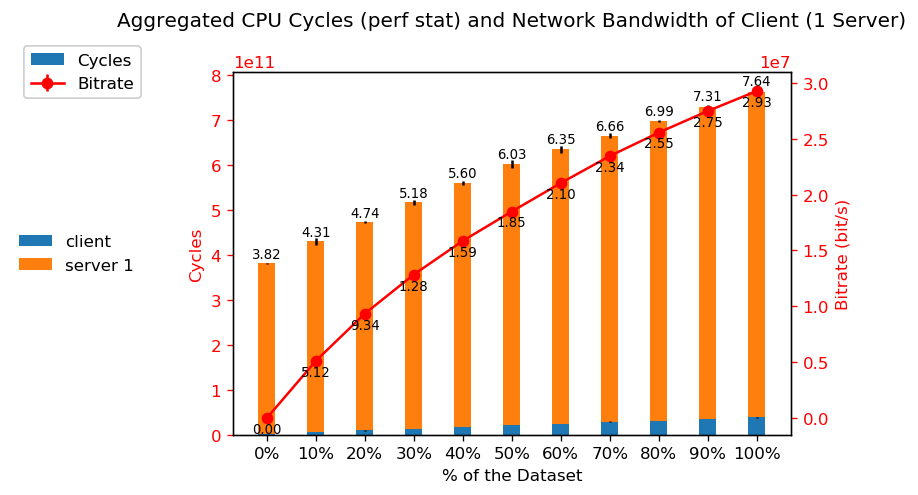

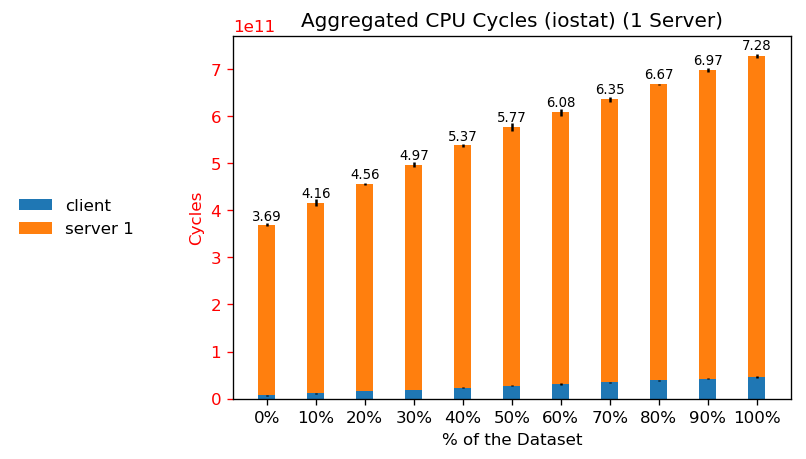

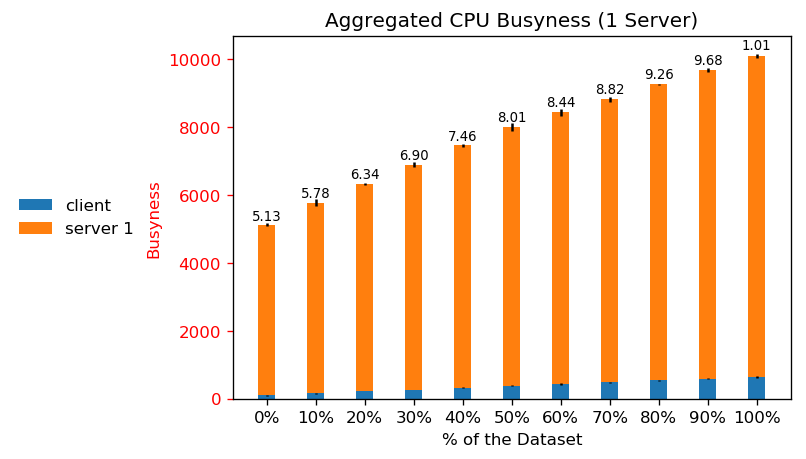

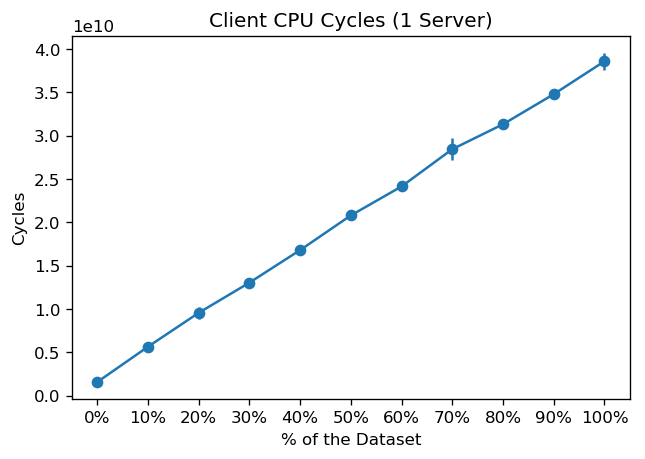

---

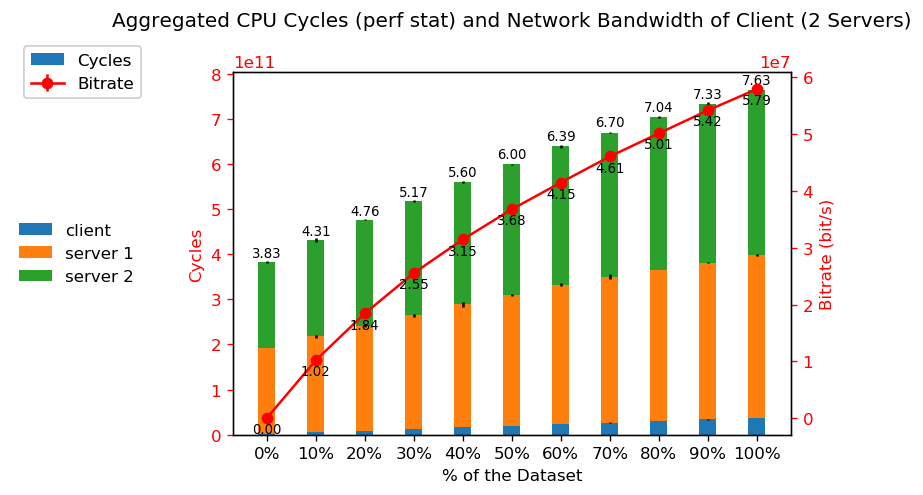

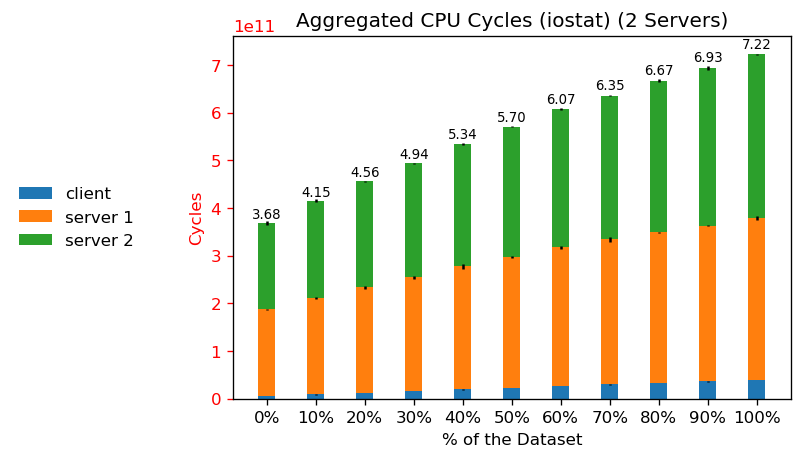

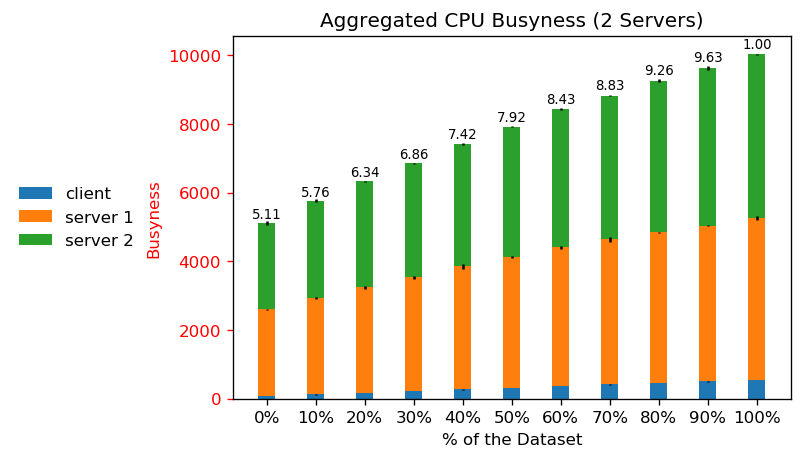

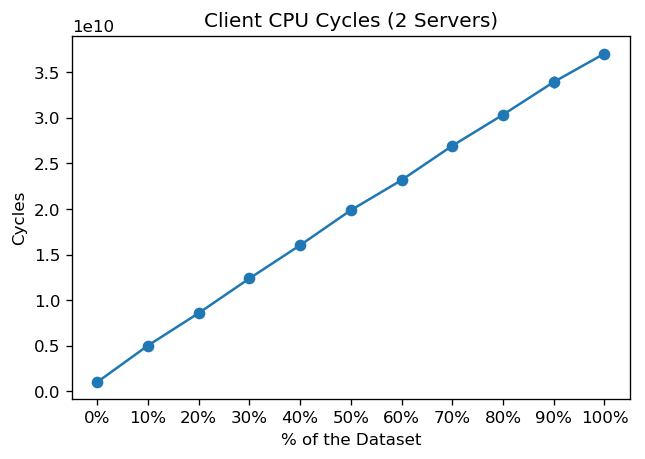

---

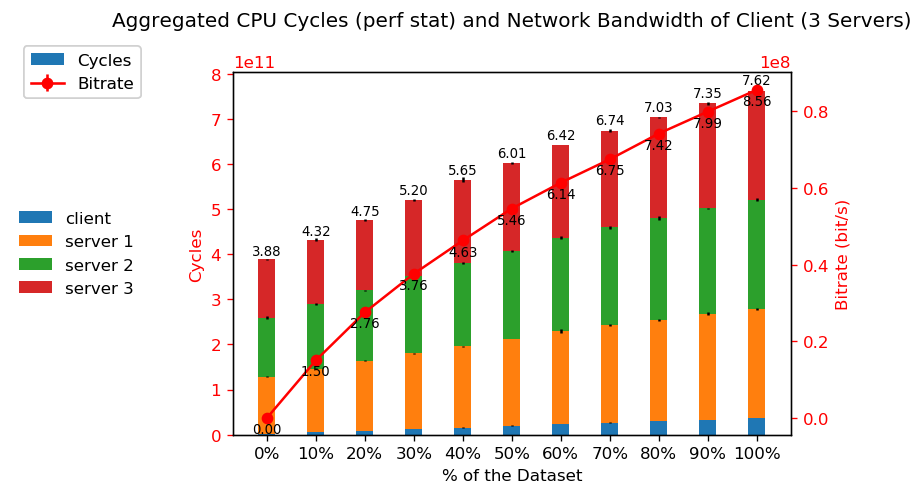

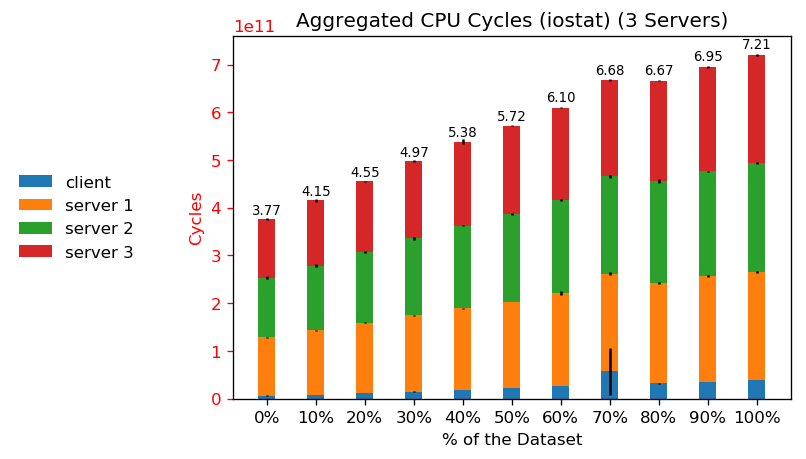

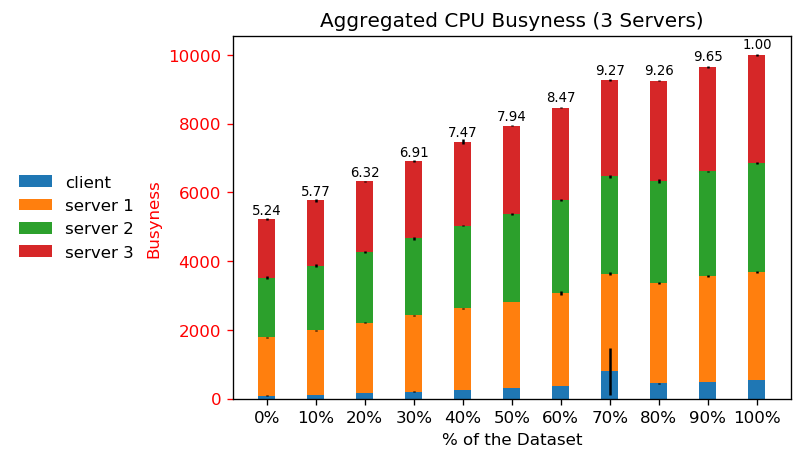

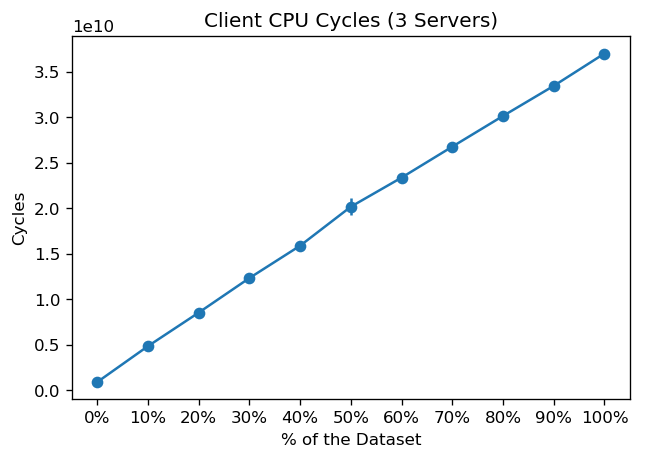

---

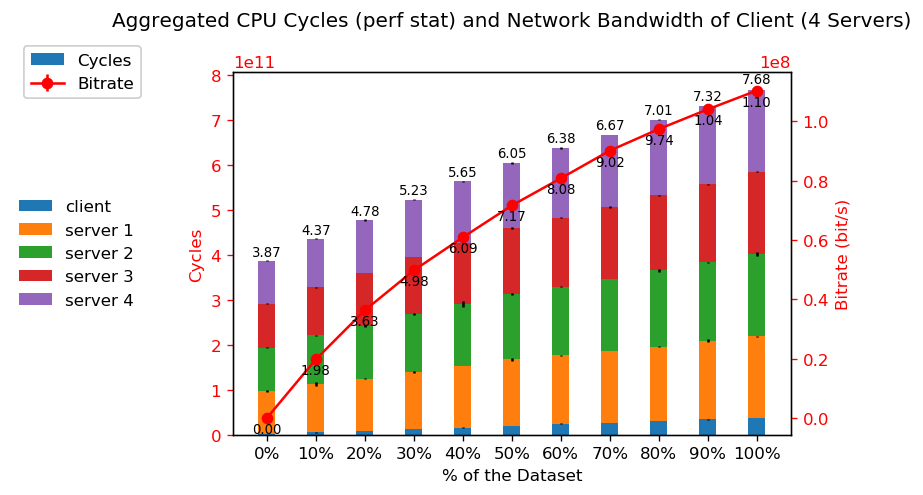

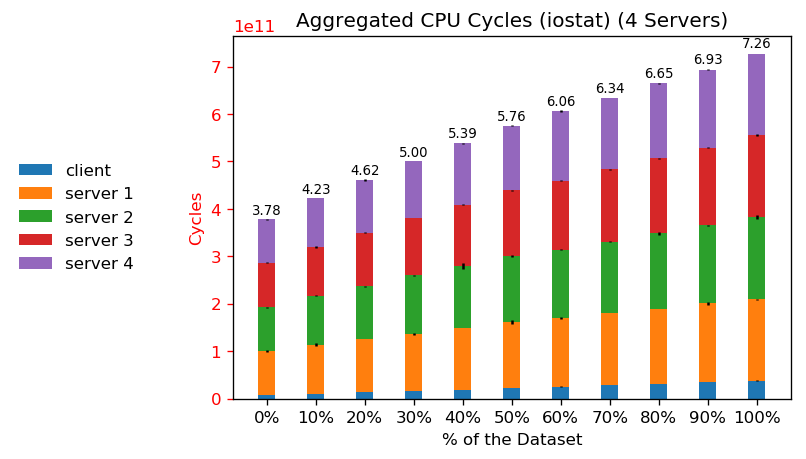

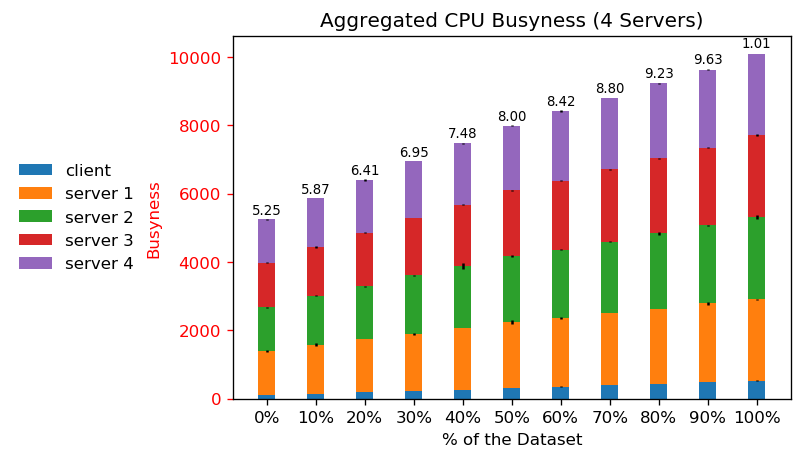

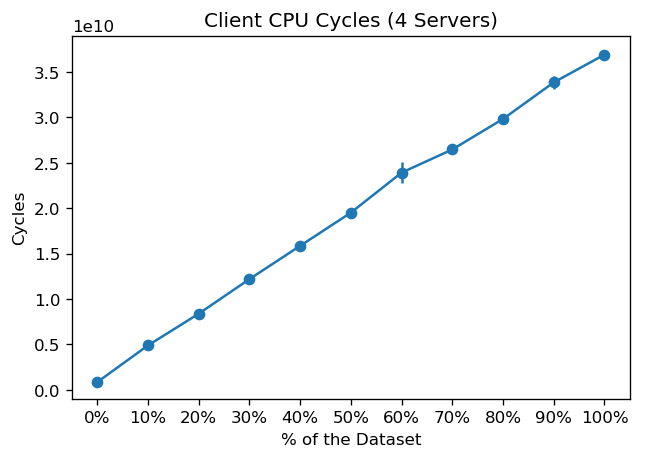

---

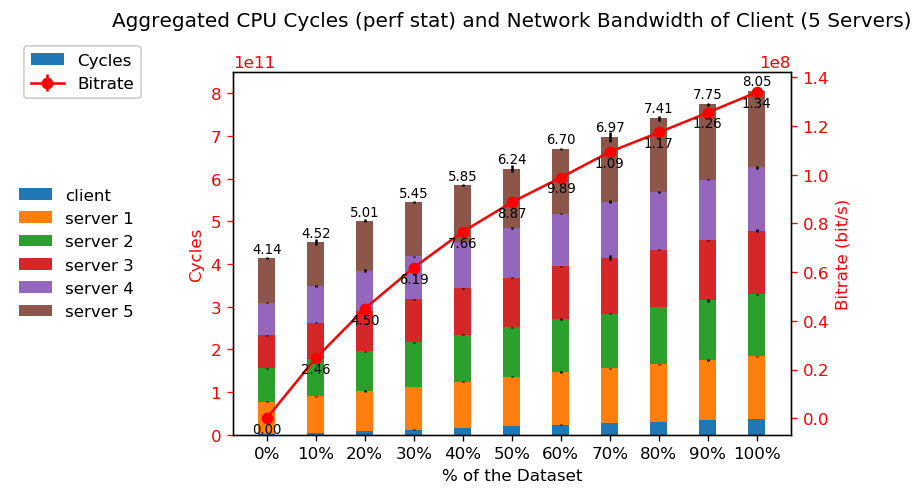

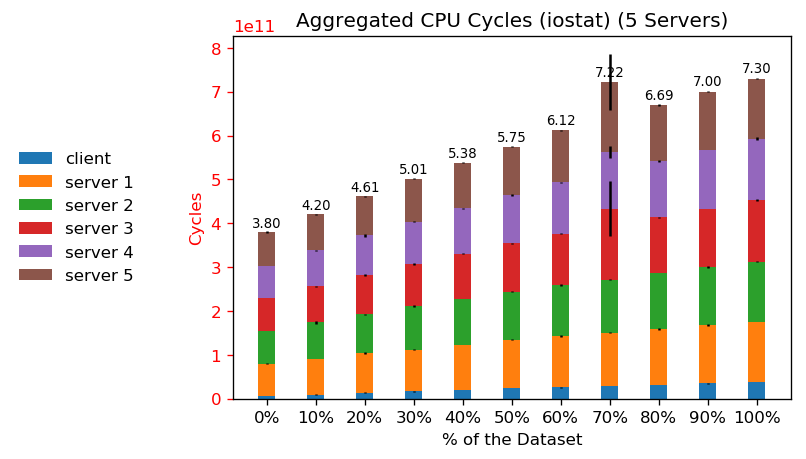

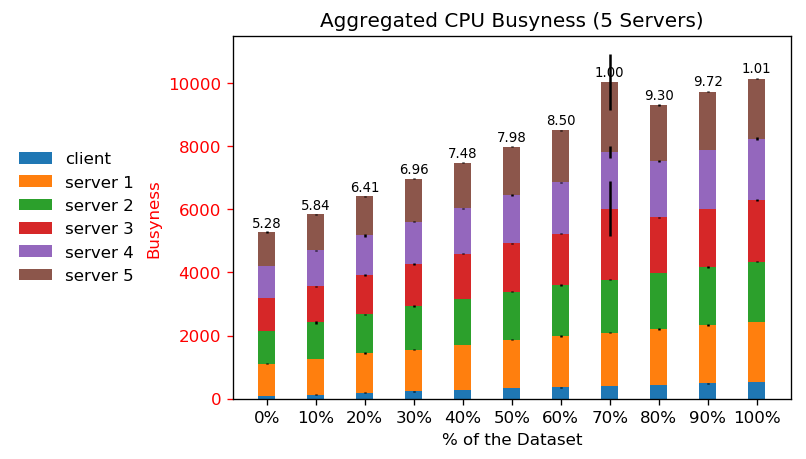

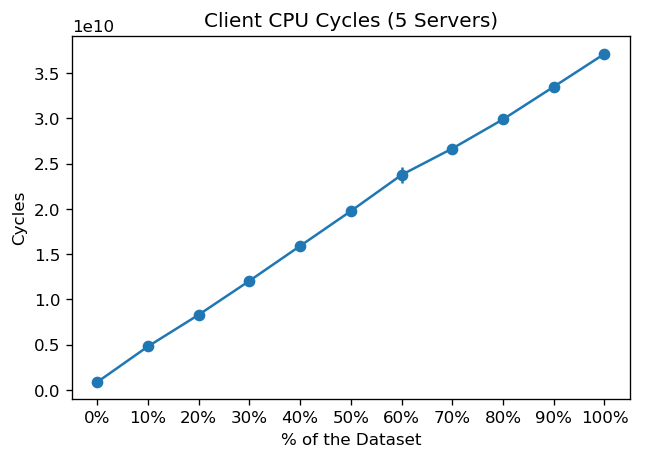

---

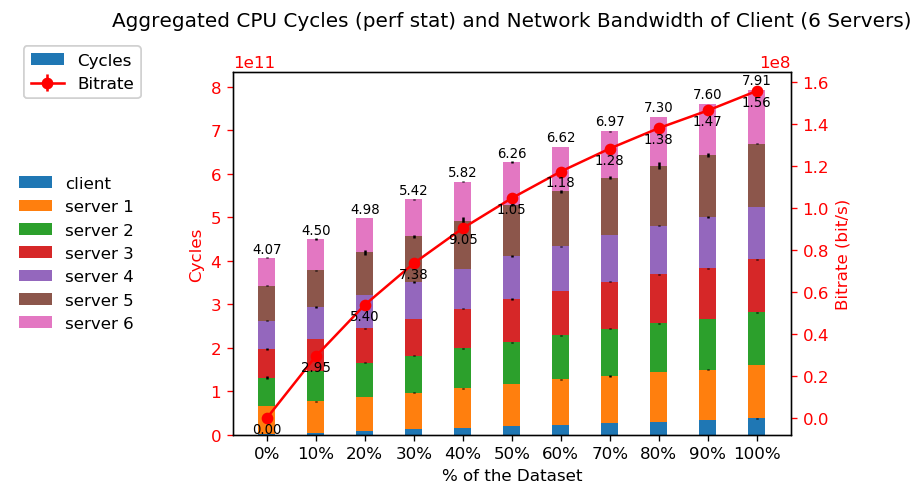

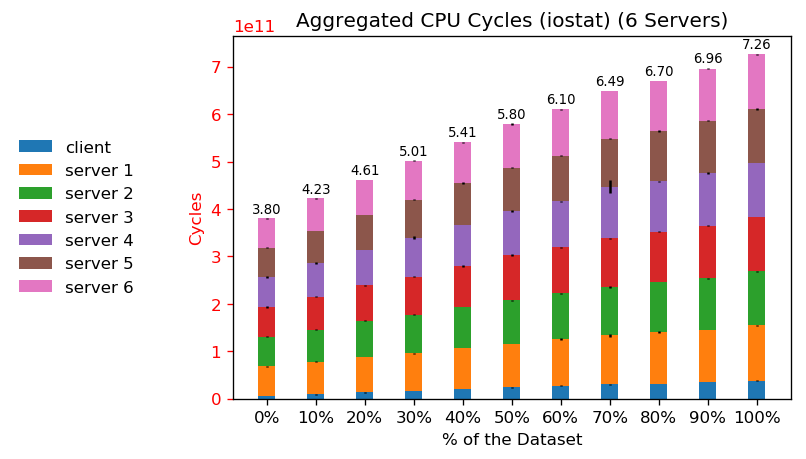

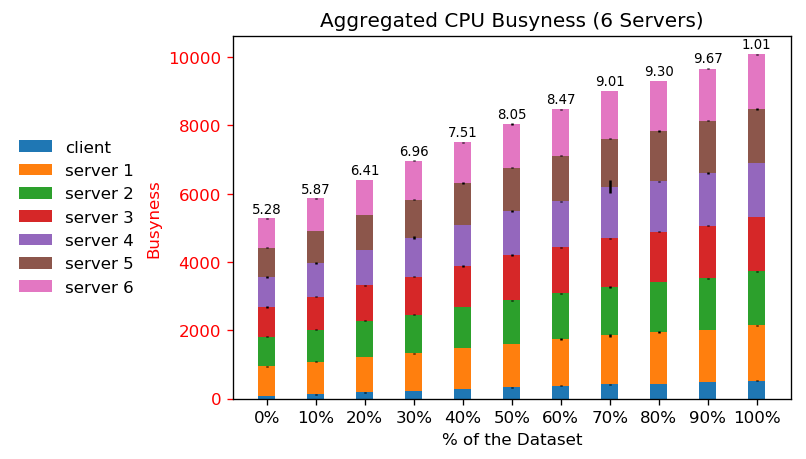

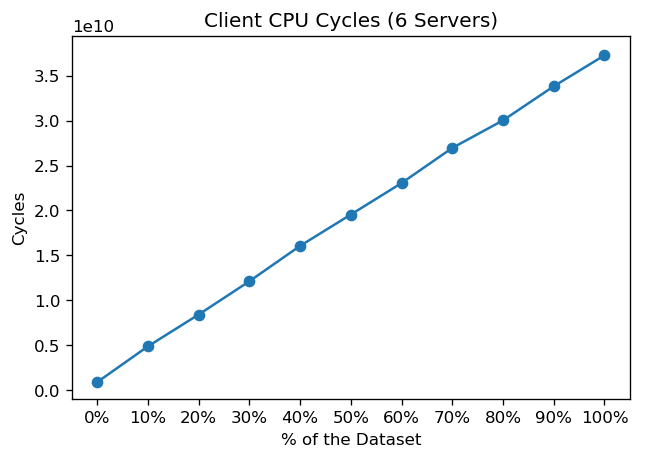

---

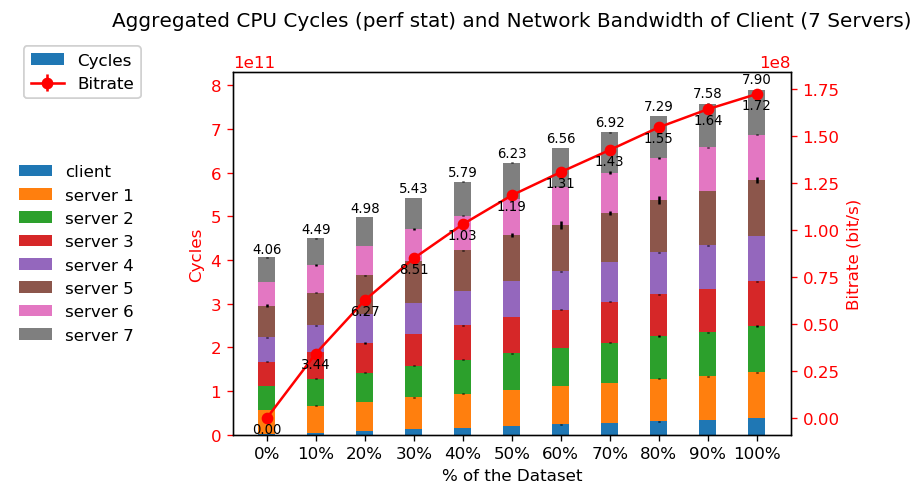

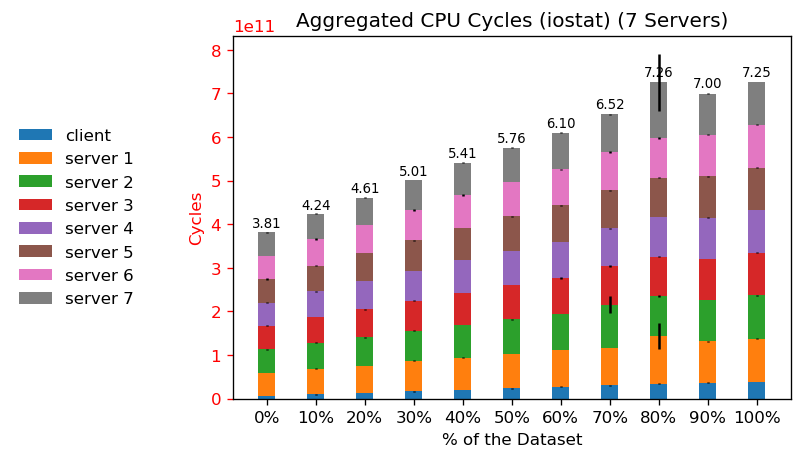

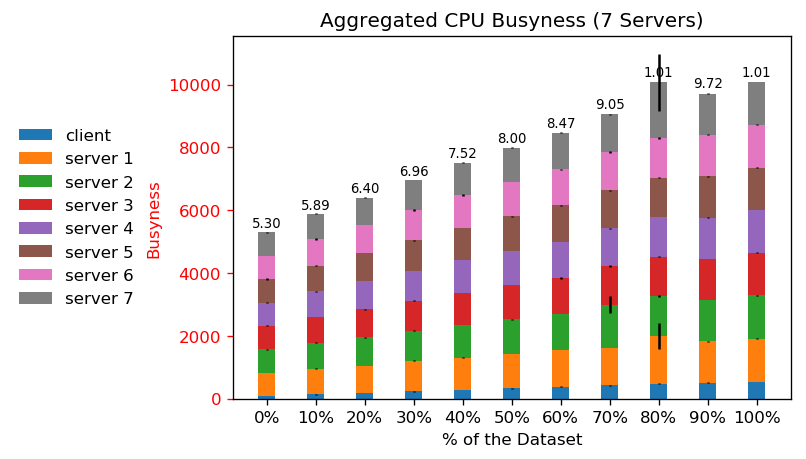

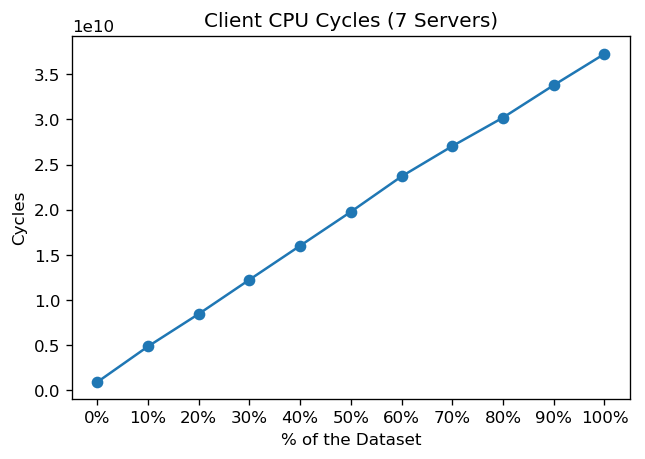

---

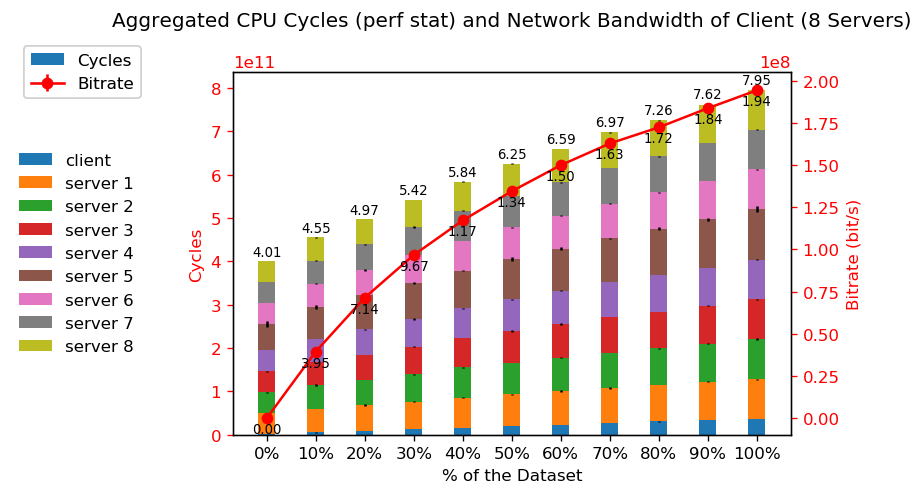

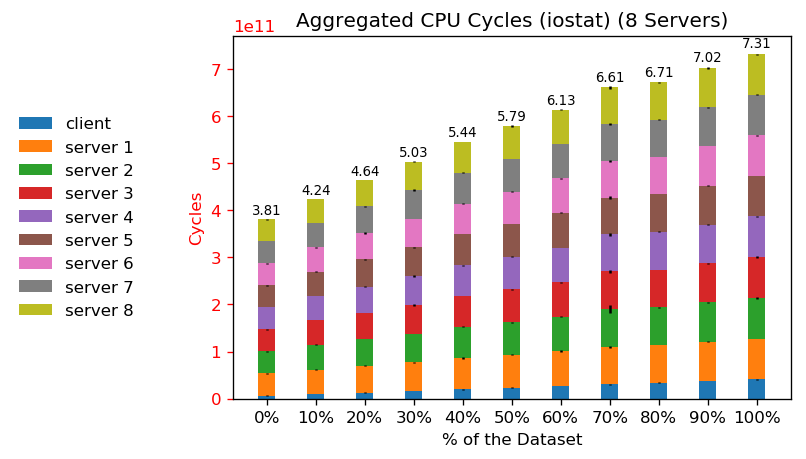

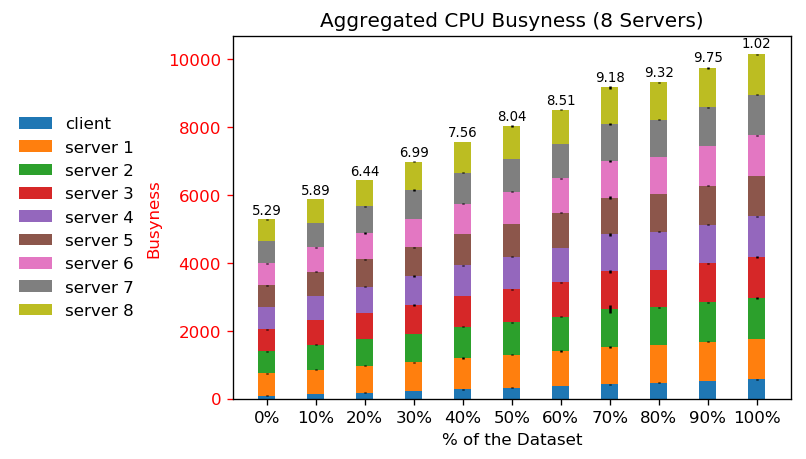

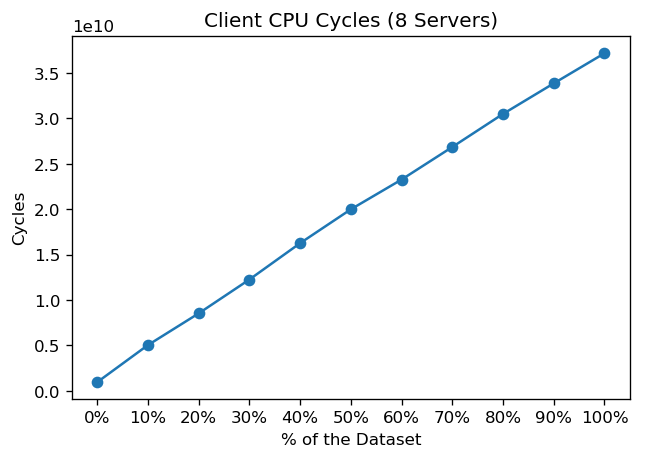

---

In [4]:
WIDTH = 0.35
YAX_CLR = 'r'

for num_servs in range(1, len(df.index) + 1):
    (ax_cycles,
     cycle_bars,
     client_cycle_avgs,
     client_cycle_stds) = __plot_bars('cycles')
    
    # Draw bitrate for client
    ax_bitrate = ax_cycles.twinx()
    
    client_bitrate_avgs = \
        [df[size][num_servs]['bitrate']['client']['avg'] for size in df_columns]
    client_bitrate_stds = \
        [df[size][num_servs]['bitrate']['client']['std'] for size in df_columns]
    
    bitrate_bar = ax_bitrate.errorbar(
        ind,
        client_bitrate_avgs,
        yerr=client_bitrate_stds,
        color=YAX_CLR,
        fmt='-o')
    
    # attach the number beside each point
    for idx in ind:
        ax_bitrate.text(idx,
                        client_bitrate_avgs[idx] - (client_bitrate_avgs[-1] * 0.055),
                        ('%.2e' % client_bitrate_avgs[idx])[:-4], fontsize=8,
                        ha='center',
                        va='bottom')
    
    ax_bitrate.set_ylabel('Bitrate (bit/s)', color=YAX_CLR)
    ax_bitrate.tick_params('y', colors=YAX_CLR)

    plt.gca().add_artist(plt.legend(
        [cycle_bars[0], bitrate_bar],
        ['Cycles', 'Bitrate'],
        loc=5,
        bbox_to_anchor=(-0.15, 1)))
    
    plt.title(
        'Aggregated CPU Cycles (perf stat) and Network Bandwidth of Client (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')', y=1.1)
    plt.show()
    
    
    # Plot the cycle numbers inferenced by the result of iostat
    
    # 1. system runs with 3 cores each at 2.4 GHz
    # 2. busyness numbers are percentages (hence divided by 100)
    escalate = 2.4 * 3 * 10**9 / 100
    
    __plot_bars('busyness', 'Cycles', escalate)
    plt.title(
        'Aggregated CPU Cycles (iostat) (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')')
    plt.show()
    
    
    # Plot the busyness numbers directly from the result of iostat
    __plot_bars('busyness')
    plt.title(
        'Aggregated CPU Busyness (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')')
    plt.show()
    
    
    # Plot the client cycles in a separated figure
    fig_client_cycles, ax_client_cycles = plt.subplots()
    fig_client_cycles.set_dpi(FIG_DPI)
    
    ax_client_cycles.errorbar(
        ind,
        client_cycle_avgs,
        yerr=client_cycle_stds,
        fmt='-o')
    
    ax_client_cycles.set_ylabel('Cycles')
    ax_client_cycles.set_xlabel('% of the Dataset')
    
    plt.xticks(ind, df_columns)
    plt.title(
        'Client CPU Cycles (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')')
    plt.show()
    
    display(Markdown('---'))

## Further Analysis

We want to use linear least-squares regression to fit the CPU cycle increasement of different number of servers.

The model we want to fit in is
```
f(x) = ax + b
```

where `f(x)` is the observed CPU cycles of running the server program, `a` is **the consumption of total CPU cycles to transmit the whole dataset**, `b` is **the rest cycles used for scanning and filtering the data** which supposed to be a constant.

We use R-squared to evaluate the quality of the regression model.

---
R-squared a statistical measure of how close the data are to the fitted regression line. It is always between 0 and 100%:

- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.

[source](http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)

---

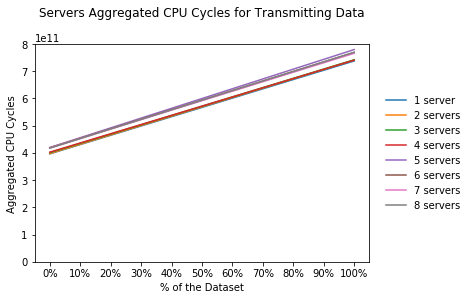

r-squareds: [0.9924431869930882, 0.99267896326329375, 0.99187829115870585, 0.99289224468772075, 0.99670581666836666, 0.99331456589700828, 0.99436151710760823, 0.9935897825264508]


In [5]:
from scipy.stats import linregress

pstgs = np.arange(0, 1.1, 0.1)

p1_args = []
r_squareds = []

for num_servs in range(1, len(df.index) + 1):
    sum_cycle_avgs = []
    for serv_idx in range(num_servs):
            server_cycle_avgs = \
                [df[size][num_servs]['cycles']['servers'][serv_idx]['avg'] for size in df_columns]
            sum_cycle_avgs = np.sum([sum_cycle_avgs, server_cycle_avgs], axis=0)

    slope, intercept, r_value, p_value, std_err = linregress(pstgs, sum_cycle_avgs)
    r_squareds.append(r_value**2)
    args = [slope, intercept]
    p1_args.append(args)
    p1 = np.poly1d(args)

    plt.plot(pstgs, p1(pstgs), '-',
             label=str(num_servs) + ' server' + ('s' if num_servs > 1 else ''))
    
plt.legend(
    loc=5,
    bbox_to_anchor=(1.3, 0.5),
    frameon=False)

plt.ylabel('Aggregated CPU Cycles')
plt.ylim(ymin=0)
plt.xlabel('% of the Dataset')
plt.xticks(pstgs, [str(int(ps * 100)) + '%' for ps in pstgs])
plt.title('Servers Aggregated CPU Cycles for Transmitting Data', y=1.1)

plt.show()

print('r-squareds: ' + repr(r_squareds))

Since for the same number of servers, the source of the difference of `Aggregated CPU Cycles` is the different size of the data transmission. We can then distill the CPU cycles consumption just for sending the data from the servers.

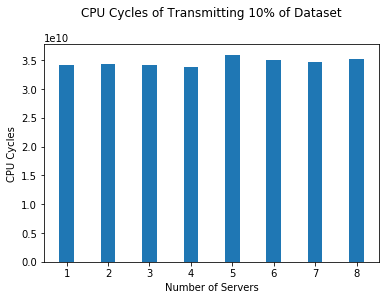

In [6]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] * 0.1 for args in p1_args], WIDTH)

ax.set_ylabel('CPU Cycles')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles of Transmitting 10% of Dataset', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

On the other hand, we can estimate how much does the cycles for transmitting the whole dataset account for the rest of work including data scaning and filtering consumed by the server program.

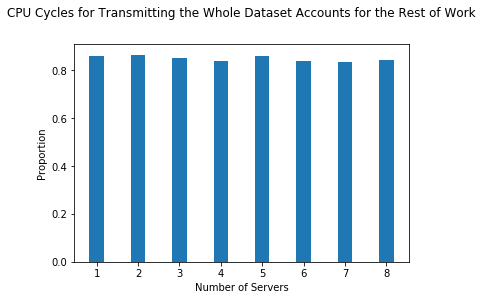

In [7]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] / args[1] for args in p1_args], WIDTH)

ax.set_ylabel('Proportion')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles for Transmitting the Whole Dataset Accounts for the Rest of Work', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

**The above figure shows we can save more than 80% of the CPU cycles consumed by the server program if we perform the data filtering right at the data source.**

We can do the same estimation for the client, where `a` and `b` in this model
```
f(x) = ax + b
```
represent the **consumption of total CPU cycles to receive the whole dataset** and **the rest of work**, respectively.

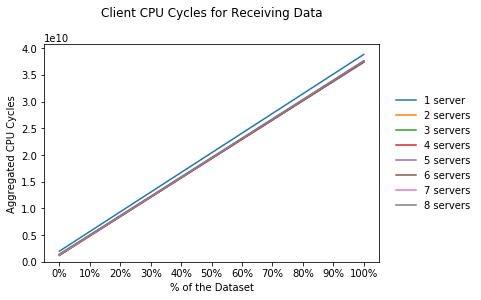

r-squareds: [0.99931583870926322, 0.99953266439405786, 0.99906152981311735, 0.99891550988828481, 0.99907746975569478, 0.99967068854241126, 0.99934420682108871, 0.99941679880094147]


In [8]:
p1_args = []
r_squareds = []

for num_servs in range(1, len(df.index) + 1):
    client_cycle_avgs = \
        [df[size][num_servs]['cycles']['client']['avg'] for size in df_columns]
    
    slope, intercept, r_value, p_value, std_err = linregress(pstgs, client_cycle_avgs)
    r_squareds.append(r_value**2)
    args = [slope, intercept]
    p1_args.append(args)
    p1 = np.poly1d(args)

    plt.plot(pstgs, p1(pstgs), '-',
             label=str(num_servs) + ' server' + ('s' if num_servs > 1 else ''))

plt.legend(
    loc=5,
    bbox_to_anchor=(1.3, 0.5),
    frameon=False)

plt.ylabel('Aggregated CPU Cycles')
plt.ylim(ymin=0)
plt.xlabel('% of the Dataset')
plt.xticks(pstgs, [str(int(ps * 100)) + '%' for ps in pstgs])
plt.title('Client CPU Cycles for Receiving Data', y=1.1)

plt.show()

print('r-squareds: ' + repr(r_squareds))

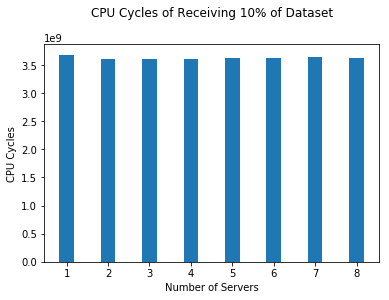

In [9]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] * 0.1 for args in p1_args], WIDTH)

ax.set_ylabel('CPU Cycles')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles of Receiving 10% of Dataset', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

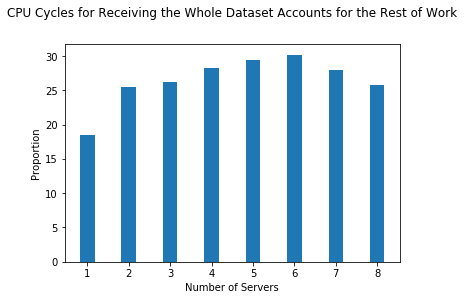

In [10]:
ind = np.arange(len(p1_args))
fig, ax = plt.subplots()
ax.bar(ind,
       [args[0] / args[1] for args in p1_args], WIDTH)

ax.set_ylabel('Proportion')
ax.set_xlabel('Number of Servers')
ax.set_title('CPU Cycles for Receiving the Whole Dataset Accounts for the Rest of Work', y=1.1)
ax.set_xticks(ind)
ax.set_xticklabels(range(1, len(p1_args) + 1))

plt.show()

The above figure makes sense because we assume the client program would use most of the time/resources just for receiving the date.